In [56]:
import random
from typing import TypedDict, Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

### Workflows

#### Data Processing (Sequential)

**1. State Schema**

In [57]:
class State(TypedDict):
    input: int
    output: int

In [58]:
workflow = StateGraph(state_schema=State)

**2. Nodes**

In [59]:
def node_a(state: State)->State:
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return State(output=output)

def node_b(state: State):
    input_value = state['output']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

In [60]:
workflow.add_node(node_a)
workflow.add_node(node_b)

**3. Edges**

In [61]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

**4. Compile and Run**

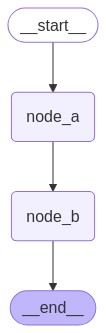

In [62]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [63]:
graph.invoke(
    input = {
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:6
 ->output:7
 
NODE B:
 ->input:7
 ->offset:10
 ->output:17
 


{'input': 1, 'output': 17}

#### Router (Conditional)

**1. State Schema**

In [64]:
class State(TypedDict):
    input: str
    action: Literal["reverse", "upper"]
    output: str

In [65]:
workflow = StateGraph(State)

**2. Nodes**

In [66]:
def node_a(state: State):
    print("Node A\n")
    output =  state['input'][::-1]
    print(f"output: {output}")
    return {"output": output}

def node_b(state: State):
    print("Node B\n")
    output = state['input'].upper()
    print(f"output: {output}")
    return {"output": output}

workflow.add_node(node_a)
workflow.add_node(node_b)


**3. Routing Function**

In [67]:
def routing_function(state: State):
    action = state["action"]
    if action == "reverse":
        return "node_a"
    if action == "upper":
        return "node_b"

**4. Edges**

Use conditional edges to control the flow of data:

- START → routing_function to decide the path.
- node_a → END for reverse.
- node_b → END for uppercase.

In add_conditional_edges() method, use source, path and path_map as the necessary arguments for routing.

In [68]:
workflow.add_conditional_edges(
    source=START, 
    path=routing_function, 
    path_map=["node_a", "node_b"]
)

workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)

**5. Compile and Run**

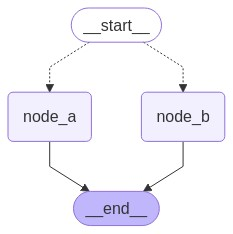

In [69]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [70]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "upper",
    }, 
)

Node B

output: SOME INPUT


{'input': 'Some input', 'action': 'upper', 'output': 'SOME INPUT'}

In [71]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "reverse",
    }, 
)

Node A

output: tupni emoS


{'input': 'Some input', 'action': 'reverse', 'output': 'tupni emoS'}

#### Call LLMs

In [72]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [73]:
class State(TypedDict):
    question: str
    response: str

In [74]:
def model(state: State):
    question = state["question"]
    response = llm.invoke([
        SystemMessage("You're a data science specialist"),
        HumanMessage(question)
    ])

    return {"response": response.content}

In [75]:
workflow = StateGraph(State)

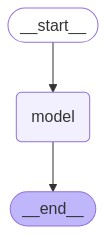

In [76]:
workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [77]:
result = graph.invoke(
    input={
        "question": "What is the Large language models?"
    }, 
)

In [78]:
result

{'question': 'What is the Large language models?',
 'response': 'Large language models (LLMs) are a type of artificial intelligence (AI) that are designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data from diverse sources, such as books, articles, websites, and more. Here are some key characteristics and concepts related to LLMs:\n\n1. **Architecture**: Most LLMs are based on transformer architecture, which allows them to process and generate text efficiently. Transformers use mechanisms like self-attention to weigh the importance of different words in a sentence, enabling them to capture context and relationships between words effectively.\n\n2. **Training**: LLMs are trained using unsupervised or semi-supervised learning methods. During training, they learn to predict the next word in a sentence given the previous words (language modeling) or to fill in 

### States